<a href="https://www.kaggle.com/code/yanncauchepin/semi-supervised-learning-mlp-binary-classifier?scriptVersionId=202061425" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Objectives

The main aim of this notebook is to share a piece of a data scientist process to realize a **Binary Classifier**.

For that, I will arbriray remove *grade* and *sub_grade* features.

The machine learning must classify whether a **loan** is classified as *Fully Paid* or *Charged Off*.

# Requirements

Before even running the following script, please follow the first steps:

- [ ] Installing the necessary librairies.

- [ ] Replacing dataset path toward your correct local repositories.

In [1]:
!pip install scipy==1.14.1
!pip install tqdm==4.66.5
!pip install openpyxl==3.1.5
!pip install pandas==2.2.3
!pip install numpy==1.26.4
!pip install pyspark==3.5.3
!pip install catboost==1.2.7
!pip install shap==0.46.0
!pip install pingouin==0.5.5
!pip install seaborn==0.13.2
!pip install torch==2.5.0
!pip install captum==0.7.0
!pip install scikit-learn==1.5.2
!pip install scikit-optimize==0.10.2
!pip install matplotlib==3.9.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 2.5 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.66.4
    Uninstalling tqdm-4.66.4:
      Successfully uninstalled tqdm-4.66.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 2024.66.154055 requires jupyterlab~=3.6.0, but you have jupyterlab 4.2.5 which is incompatible.
conda 24.9.0 requires packaging>=23.0, but you have packaging 21.3 which is incompatible.
ydata-profiling 4.10.0 requires scipy<1.14,>=1.4.1, but you have scipy 1.14.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840

In [2]:
metadata_path = "/kaggle/input/lending-club-20072020q1/LCDataDictionary.xlsx"
data_path = "/kaggle/input/lending-club-20072020q1/Loan_status_2007-2020Q3.gzip"

# Data Importation

I initially plan to use **[Pandas](https://pandas.pydata.org/)** librairy to manipulate data in a common way. Since my computer freeze over many times, I decided to use **[Spark](https://spark.apache.org/)** library to tackle this significative amount of data. This library involve map-reduce method to handle big data more efficiently.

In [3]:
import pandas as pd
metadata = pd.read_excel(metadata_path, index_col=0)
metadata = metadata.iloc[:-2,:]

In [4]:
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("LendingClubDataProcessing") \
    .getOrCreate()

df_spark = spark.read.csv(data_path, header=True, inferSchema=True)
print(f"Number of data: {df_spark.count()}")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/19 14:19:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Number of data: 2925493


# Data Cleaning - Encoding Target

Since the dataset was filled with metadata, I decided to check the consistency of the data to remove outer features. 

In [5]:
print(f"Metadata features: {len(metadata.index)}")
print(f"Data features: {len(df_spark.columns)}")

outer_features = [feature for feature in df_spark.columns if feature not in metadata.index]

print(f"Unknown data features: {outer_features} ({len(outer_features)})")
df_spark = df_spark.drop(*outer_features)

Metadata features: 151
Data features: 142
Unknown data features: ['_c0', 'verification_status_joint', 'total_rev_hi_lim', 'revol_bal_joint', 'sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med'] (14)


In [6]:
features_to_drop = ['grade', 'sub_grade']
df_spark = df_spark.drop(*features_to_drop)

## Target feature

The **loan_status** feature, which is our target variable, contains other values than *Fully Paid* and *Charged Off*. Therefore, I decided to encode the rest to NaN.

In [7]:
value_counts = df_spark.groupBy('loan_status').count()
value_rate = value_counts.count() / df_spark.count()
print(f"Number of distincts values: {value_counts.count()} - {value_rate:.2e} %")
value_counts.show()

Number of distincts values: 12 - 4.10e-06 %


+--------------------+-------+
|         loan_status|  count|
+--------------------+-------+
|          Fully Paid|1497783|
|                NULL|      1|
|     In Grace Period|  10028|
|Does not meet the...|   1988|
|         Charged Off| 362547|
|  Late (31-120 days)|  16154|
|             Current|1031016|
|Does not meet the...|    761|
|   Late (16-30 days)|   2719|
|             Default|    433|
|              Issued|   2062|
|            Oct-2015|      1|
+--------------------+-------+



In [8]:
import numpy as np

'''
mapping = {
    'Fully Paid': 0,
    'Charged Off': 1,
    'Current': np.nan,
    'Late (31-120 days)': np.nan,
    'In Grace Period': np.nan,
    'Late (16-30 days)': np.nan,
    'Issued': np.nan,
    'Does not meet the credit policy. Status:Fully Paid': np.nan,
    'Does not meet the credit policy. Status:Charged Off': np.nan,
    'Default': np.nan,
    'Oct-2015': np.nan
}
'''

from pyspark.sql.functions import when
df_spark = df_spark.withColumn("loan_status", when(df_spark["loan_status"] == "Fully Paid", 0)
                   .when(df_spark["loan_status"] == "Charged Off", 1)
                   .otherwise(np.nan))

In [9]:
all_features = [feature for feature in df_spark.columns if feature != 'loan_status']
df_spark = df_spark.fillna({feature: "nan" if df_spark.schema[feature].dataType == 'string' else np.nan for feature in all_features})

In [10]:
value_counts = df_spark.groupBy('loan_status').count()
value_rate = value_counts.count() / df_spark.count()
print(f"Number of distincts values: {value_counts.count()} - {value_rate:.2e} %")
value_counts.show()

Number of distincts values: 3 - 1.03e-06 %


+-----------+-------+
|loan_status|  count|
+-----------+-------+
|        0.0|1497783|
|        NaN|1065163|
|        1.0| 362547|
+-----------+-------+



We can see that there is a large amount of NaN values, which could be a raw deal to avoid them in the process.

From this point, it is almost clear that we will proceed to a **semi-supervised** learning. This involves learning from both taged and untaged data.

A good pratice is also to have an overview of other variable types to assess the complexity of encoding inputs.

In [11]:
df_spark.dtypes

[('id', 'string'),
 ('loan_amnt', 'int'),
 ('funded_amnt', 'int'),
 ('funded_amnt_inv', 'double'),
 ('term', 'string'),
 ('int_rate', 'string'),
 ('installment', 'double'),
 ('emp_title', 'string'),
 ('emp_length', 'string'),
 ('home_ownership', 'string'),
 ('annual_inc', 'string'),
 ('verification_status', 'string'),
 ('issue_d', 'string'),
 ('loan_status', 'double'),
 ('pymnt_plan', 'string'),
 ('url', 'string'),
 ('purpose', 'string'),
 ('title', 'string'),
 ('zip_code', 'string'),
 ('addr_state', 'string'),
 ('dti', 'string'),
 ('delinq_2yrs', 'double'),
 ('earliest_cr_line', 'string'),
 ('fico_range_low', 'string'),
 ('fico_range_high', 'int'),
 ('inq_last_6mths', 'int'),
 ('mths_since_last_delinq', 'int'),
 ('mths_since_last_record', 'int'),
 ('open_acc', 'int'),
 ('pub_rec', 'int'),
 ('revol_bal', 'int'),
 ('revol_util', 'string'),
 ('total_acc', 'string'),
 ('initial_list_status', 'string'),
 ('out_prncp', 'string'),
 ('out_prncp_inv', 'double'),
 ('total_pymnt', 'double'),
 ('

# Data Reduction

With the complex structure of the table data, mixing types and nan, an advanced analysis would be interesting to pursue a modeling process. However, there is a interesting preprocess that consist to reduce the mix data into a low dimensional relevant data. In fact, this is common in large matrix of data where we can decompose it into a lower format which contains a significative explanative information. This is the case in mathematics with matrix decomposition, and an example of compressing files.

Moreover, reducing data in the modeling part could be interesting for daily professional users. Indeed, assuming the model perform well, it could be boring to insert all the data to assess a loan status. And all the data is not always available for daily uses.

Here, a usefull process is to reduce the amount of features to the more relevant one by gradient boosting modeling. It is possible to extract the features importances of a tree model, whether it concerns classification or regression, and pursue our modeling work on the most important features. The question of the threshold is critical. Here I deciced to limit it by the selecting those until the cumulative explainibility exceed 90% of the total sum.

In practice, the use of gradient boosting implementation depends on the data structure or on the underlying computed processes. Even if **[XGBoost](https://xgboost.readthedocs.io/en/stable/)** is widely 
used and usually represent the best models in Kaggle, others librairies exist. Here, I decided to use the library **[Catboost](https://catboost.ai/)** for it is inner preprocessing of categorical variables, which is not present in **XGBoost**. Since I have not enough time with this short notebook to encode all categorical features by myself, it is highly interesting. Of course, the evaluation of feature importances of this model will depends on the inner encoding process of **Catboost**, which will be certainly not reproduced in the next step. Additionnaly, I decided to not tune its hyperparameters or run it through several iterations. The training was perform on a small sample of the entire data to simplify this step and not demanding to much on computer. I use the library **[Shap](https://shap.readthedocs.io/en/latest/index.html)** to get the features importances ; shapely additive explanations values are based on cooperative game theory.

An interesting cross-validation would be the expertise of professionals who have intuitive knowledge. Obvsiously, the machine learning tools bring probably a better analysis. But, when we hesitate between two features, for example if two feature have a high correlation between them and a similar feature importance. My personal experience with physicians usually leads me to not exclude those opportunity of cross-validation. 

In [12]:
df_gb = df_spark.sample(fraction=0.05, seed=11)
print(f"Number of data: {df_gb.count()}")

Number of data: 146202


In [13]:
df_gb = df_gb.dropna(subset=['loan_status'])
print(f"Number of data: {df_gb.count()}")

Number of data: 93025


In [14]:
features_gb = df_gb.select(all_features)
features_collected_gb = features_gb.collect()
target_gb = df_gb.select('loan_status')
target_collected_gb = target_gb.collect()

24/10/19 14:21:56 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [15]:
X_gb = np.array([list(feature) for feature in features_collected_gb])

In [16]:
y_gb = np.array([feature['loan_status'] for feature in target_collected_gb])

In [17]:
X_gb.shape

(93025, 125)

In [18]:
y_gb.shape

(93025,)

In [19]:
categorical_features = [feature for (feature, dtype) in df_gb.dtypes if dtype=='string']

In [20]:
from catboost import Pool, CatBoostClassifier

pool = Pool(data=X_gb, label=y_gb, feature_names=all_features, cat_features=categorical_features)

catboost_model = CatBoostClassifier(iterations=100)
catboost_model.fit(pool)

Learning rate set to 0.5
0:	learn: 0.1340758	total: 275ms	remaining: 27.2s
1:	learn: 0.0657807	total: 480ms	remaining: 23.5s
2:	learn: 0.0537688	total: 639ms	remaining: 20.6s
3:	learn: 0.0310342	total: 816ms	remaining: 19.6s
4:	learn: 0.0221494	total: 982ms	remaining: 18.7s
5:	learn: 0.0194756	total: 1.14s	remaining: 17.9s
6:	learn: 0.0177935	total: 1.31s	remaining: 17.4s
7:	learn: 0.0166727	total: 1.5s	remaining: 17.2s
8:	learn: 0.0145362	total: 1.66s	remaining: 16.8s
9:	learn: 0.0140322	total: 1.82s	remaining: 16.4s
10:	learn: 0.0136192	total: 1.97s	remaining: 16s
11:	learn: 0.0136039	total: 2.13s	remaining: 15.6s
12:	learn: 0.0127980	total: 2.3s	remaining: 15.4s
13:	learn: 0.0124900	total: 2.49s	remaining: 15.3s
14:	learn: 0.0114356	total: 2.71s	remaining: 15.4s
15:	learn: 0.0114356	total: 2.81s	remaining: 14.7s
16:	learn: 0.0112402	total: 3.02s	remaining: 14.8s
17:	learn: 0.0104225	total: 3.24s	remaining: 14.8s
18:	learn: 0.0103428	total: 3.44s	remaining: 14.7s
19:	learn: 0.0090752

In [21]:
import shap
explainer = shap.Explainer(catboost_model)
shap_values = explainer.shap_values(X_gb)

In [22]:
sum_over_feature = np.sum(np.abs(shap_values), axis=0)
feature_importance = pd.DataFrame(data=sum_over_feature, index=all_features, columns=['feature_importance'])
feature_importance = feature_importance[feature_importance['feature_importance']>0]
feature_importance = feature_importance.sort_values(by='feature_importance', ascending=False)
feature_importance.shape
feature_importance

feature_importance
total_rec_prncp                      467999.431103
recoveries                           180144.575175
funded_amnt_inv                      134494.251953
funded_amnt                          121459.879049
last_fico_range_high                  98390.730082
...                                            ...
pub_rec_bankruptcies                      0.415480
num_actv_bc_tl                            0.253597
verification_status                       0.027070
hardship_payoff_balance_amount            0.007355
total_cu_tl                               0.001270

[100 rows x 1 columns]

In [23]:
feature_importance['cumulative_sum'] = feature_importance['feature_importance'].cumsum()
total_sum = feature_importance['feature_importance'].sum()
feature_importance['rate'] = feature_importance['cumulative_sum'] / total_sum
feature_importance

feature_importance  cumulative_sum      rate
total_rec_prncp                      467999.431103    4.679994e+05  0.300582
recoveries                           180144.575175    6.481440e+05  0.416284
funded_amnt_inv                      134494.251953    7.826383e+05  0.502666
funded_amnt                          121459.879049    9.040981e+05  0.580676
last_fico_range_high                  98390.730082    1.002489e+06  0.643869
...                                            ...             ...       ...
pub_rec_bankruptcies                      0.415480    1.556976e+06  1.000000
num_actv_bc_tl                            0.253597    1.556976e+06  1.000000
verification_status                       0.027070    1.556976e+06  1.000000
hardship_payoff_balance_amount            0.007355    1.556976e+06  1.000000
total_cu_tl                               0.001270    1.556976e+06  1.000000

[100 rows x 3 columns]

In [24]:
threshold = 0.9
selected_features = feature_importance[feature_importance['rate'] < threshold].index
selected_features
len(selected_features)

15

In [25]:
features_to_drop = [feature for feature in all_features if feature not in selected_features]
features_to_drop
len(features_to_drop)

110

In [26]:
df_spark = df_spark.drop(*features_to_drop)

# Data Cleaning - Encoding

Now that 17 features are selected, it is time to clean them in a more appropriate way. To analyse the spark dataframe, the code below allows to highlight the cleaning need of each feature. I recommand you to run it before and after the following cleaning scripts if you would like to better understand it.

### Imputation

In a advanced version, I would impute nan with a more sophisticated process than by the mean of each feature. This could be executed by a modeling imputation with the use of machine learning models. Among many possibilities, it exists k-nearest neighbors imputations or deep learning-based imputations. Nevertheless, we can observe than there is only few data containing nan so it is not so critical for a quick hands-on.

In [27]:
# from pyspark.sql.functions import isnan
# for feature, dtype in df_spark.dtypes:
#     print("====================================")
#     print(f"FEATURE: {feature}")
#     if dtype=='string':
#         value_counts = df_spark.groupBy(feature).count()
#         value_rate = value_counts.count() / df_spark.count()
#         print(f"Number of distincts values: {value_counts.count()} - {value_rate:.2e} %")
#         value_counts.show()
#     nan_count = df_spark.filter(df_spark[feature].isNull() | isnan(df_spark[feature])).count()
#     nan_rate = nan_count / df_spark.count()
#     print(f"{nan_count} NaN - {nan_rate:.2e} %")
#     print("\n")

In [28]:
print("====================================")
feature = 'last_pymnt_d'
print(f"FEATURE: {feature}")
value_counts = df_spark.groupBy(feature).count()
value_counts.show()

FEATURE: last_pymnt_d


+------------+-----+
|last_pymnt_d|count|
+------------+-----+
|    Oct-2016|22937|
|    Sep-2017|26750|
|    Jul-2009|   72|
|    May-2015|11070|
|    Jun-2020|35299|
|    Aug-2014| 6308|
|    Apr-2013| 1910|
|    Jun-2019|33371|
|    Jan-2012|  575|
|    May-2010|  151|
|    Sep-2008|   40|
|    Dec-2014| 7255|
|    Jan-2011|  330|
|    Nov-2008|   31|
|    Nov-2012| 1198|
|    Jul-2010|  247|
|    Jun-2011|  440|
|    Nov-2009|   80|
|    Jan-2008|   11|
|    Dec-2008|   31|
+------------+-----+
only showing top 20 rows



In [29]:
def to_float(value):
    try:
        return float(value)
    except ValueError:
        return np.nan

from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf

to_float_udf = udf(to_float, FloatType())
df_spark = df_spark.withColumn("last_fico_range_high", to_float_udf(df_spark["last_fico_range_high"]))
df_spark = df_spark.withColumn("last_pymnt_amnt", to_float_udf(df_spark["last_pymnt_amnt"]))

In [30]:
df_spark.createOrReplaceTempView("lending_club_1")
sql_expression = """
CASE
    WHEN last_pymnt_d LIKE 'Jan-%' THEN CAST(SUBSTRING(last_pymnt_d, 5) AS FLOAT) + 0/12
    WHEN last_pymnt_d LIKE 'Feb-%' THEN CAST(SUBSTRING(last_pymnt_d, 5) AS FLOAT) + 1/12
    WHEN last_pymnt_d LIKE 'Mar-%' THEN CAST(SUBSTRING(last_pymnt_d, 5) AS FLOAT) + 2/12
    WHEN last_pymnt_d LIKE 'Apr-%' THEN CAST(SUBSTRING(last_pymnt_d, 5) AS FLOAT) + 3/12
    WHEN last_pymnt_d LIKE 'May-%' THEN CAST(SUBSTRING(last_pymnt_d, 5) AS FLOAT) + 4/12
    WHEN last_pymnt_d LIKE 'Jun-%' THEN CAST(SUBSTRING(last_pymnt_d, 5) AS FLOAT) + 5/12
    WHEN last_pymnt_d LIKE 'Jul-%' THEN CAST(SUBSTRING(last_pymnt_d, 5) AS FLOAT) + 6/12
    WHEN last_pymnt_d LIKE 'Aug-%' THEN CAST(SUBSTRING(last_pymnt_d, 5) AS FLOAT) + 7/12
    WHEN last_pymnt_d LIKE 'Sep-%' THEN CAST(SUBSTRING(last_pymnt_d, 5) AS FLOAT) + 8/12
    WHEN last_pymnt_d LIKE 'Oct-%' THEN CAST(SUBSTRING(last_pymnt_d, 5) AS FLOAT) + 9/12
    WHEN last_pymnt_d LIKE 'Nov-%' THEN CAST(SUBSTRING(last_pymnt_d, 5) AS FLOAT) + 10/12
    WHEN last_pymnt_d LIKE 'Dec-%' THEN CAST(SUBSTRING(last_pymnt_d, 5) AS FLOAT) + 11/12
    ELSE NULL
END AS last_pymnt_d_num
"""
df_spark = spark.sql(f"""
SELECT *, {sql_expression}
FROM lending_club_1
""")

df_spark = df_spark.drop("last_pymnt_d")
df_spark = df_spark.withColumnRenamed('last_pymnt_d_num', 'last_pymnt_d')

In [31]:
df_spark.createOrReplaceTempView("lending_club_2")
sql_expression = """
CASE
    WHEN last_credit_pull_d LIKE 'Jan-%' THEN CAST(SUBSTRING(last_credit_pull_d, 5) AS FLOAT) + 0/12
    WHEN last_credit_pull_d LIKE 'Feb-%' THEN CAST(SUBSTRING(last_credit_pull_d, 5) AS FLOAT) + 1/12
    WHEN last_credit_pull_d LIKE 'Mar-%' THEN CAST(SUBSTRING(last_credit_pull_d, 5) AS FLOAT) + 2/12
    WHEN last_credit_pull_d LIKE 'Apr-%' THEN CAST(SUBSTRING(last_credit_pull_d, 5) AS FLOAT) + 3/12
    WHEN last_credit_pull_d LIKE 'May-%' THEN CAST(SUBSTRING(last_credit_pull_d, 5) AS FLOAT) + 4/12
    WHEN last_credit_pull_d LIKE 'Jun-%' THEN CAST(SUBSTRING(last_credit_pull_d, 5) AS FLOAT) + 5/12
    WHEN last_credit_pull_d LIKE 'Jul-%' THEN CAST(SUBSTRING(last_credit_pull_d, 5) AS FLOAT) + 6/12
    WHEN last_credit_pull_d LIKE 'Aug-%' THEN CAST(SUBSTRING(last_credit_pull_d, 5) AS FLOAT) + 7/12
    WHEN last_credit_pull_d LIKE 'Sep-%' THEN CAST(SUBSTRING(last_credit_pull_d, 5) AS FLOAT) + 8/12
    WHEN last_credit_pull_d LIKE 'Oct-%' THEN CAST(SUBSTRING(last_credit_pull_d, 5) AS FLOAT) + 9/12
    WHEN last_credit_pull_d LIKE 'Nov-%' THEN CAST(SUBSTRING(last_credit_pull_d, 5) AS FLOAT) + 10/12
    WHEN last_credit_pull_d LIKE 'Dec-%' THEN CAST(SUBSTRING(last_credit_pull_d, 5) AS FLOAT) + 11/12
    ELSE NULL
END AS last_credit_pull_d_num
"""
df_spark = spark.sql(f"""
SELECT *, {sql_expression}
FROM lending_club_2
""")

df_spark = df_spark.drop("last_credit_pull_d")
df_spark = df_spark.withColumnRenamed('last_credit_pull_d_num', 'last_credit_pull_d')

In [32]:
convert_to_float_rate = udf(lambda x: float(x.replace('%', '')) / 100, FloatType())
df_spark = df_spark.withColumn('int_rate', convert_to_float_rate(df_spark['int_rate']))

In [33]:
from pyspark.ml.feature import Imputer

numerical_selected_features = [feature for (feature, dtype) in df_spark.dtypes if (dtype!='string' and feature !='loan_status')]

imputer = Imputer(
    inputCols=numerical_selected_features,
    outputCols=numerical_selected_features
).setStrategy("mean")

df_spark = imputer.fit(df_spark).transform(df_spark)

# Data Analysis

### Correlation

It is obvioulsy interesting to analysis correlation, or even partial correlation, between features to identify whether some selected features could be additionnaly removed. Indeed, there could be an issue while modeling colinear features, which could be observed by a brute correlation equals to 1.

Moreover, it is interesting to evaluate the partial correlations by removing the covariance on the different features. It allows to extract the direct relationship between each pair of features. A highly partial correlation could be the origin of an unnecessary dimension modeling. Therefore, the data reduction could be also improved here by removing features included in pair of partial correlation with high values, and which have the lowest features importances, i.e. provided here by gradient boosting. The question of the threshold is still critical here, as it was in the data reduction. 


### Distribution over the *loan_status* target

An other aspect of unrelevant features could be the significative difference between the distribution of features among all the modalities of the target *loan_status*. Here I plot the boxplot of each feature whether it concerns the *Charged Off* or *Fully Paid*, and I run a statistical test to evaluate the null hypothesis that there is a significative difference observing the means of the distinct distribtutions. Sometimes, graphical displays do not match with the statistical test.

### Note

I have honestyly prioritized the modeling section to return a productive work. This section was therefore performed at the end of the hands-on. So the conclusion it provides will not be applied in the rest of this work. Considering the observation of this section, it would be interesting to evaluate the relevance of considering or not each debatable features in the modeling part. 

But keep in mind this analysis was processed on a small set from the entire data...

In [34]:
df = df_spark.sample(fraction=0.005, seed=1)
print(f"Number of data: {df.count()}")
df_labeled = df.dropna(subset=['loan_status'])
print(f"Number of labeled data: {df_labeled.count()}")

Number of data: 14518


Number of labeled data: 9247


In [35]:
features = [feature for feature in list(df_spark.columns) if feature != 'loan_status']

In [36]:
features_collected = df_labeled.select(features).collect()
target_collected = df_labeled.select('loan_status').collect()
X_labeled = np.array([list(feature) for feature in features_collected], dtype=float)
y_labeled = np.array([feature['loan_status'] for feature in target_collected], dtype=float)
y_labeled = y_labeled.astype(int)

In [37]:
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt

In [38]:
df_combined = pd.DataFrame(X_labeled.astype(float), columns=features)
df_combined['loan_status'] = y_labeled

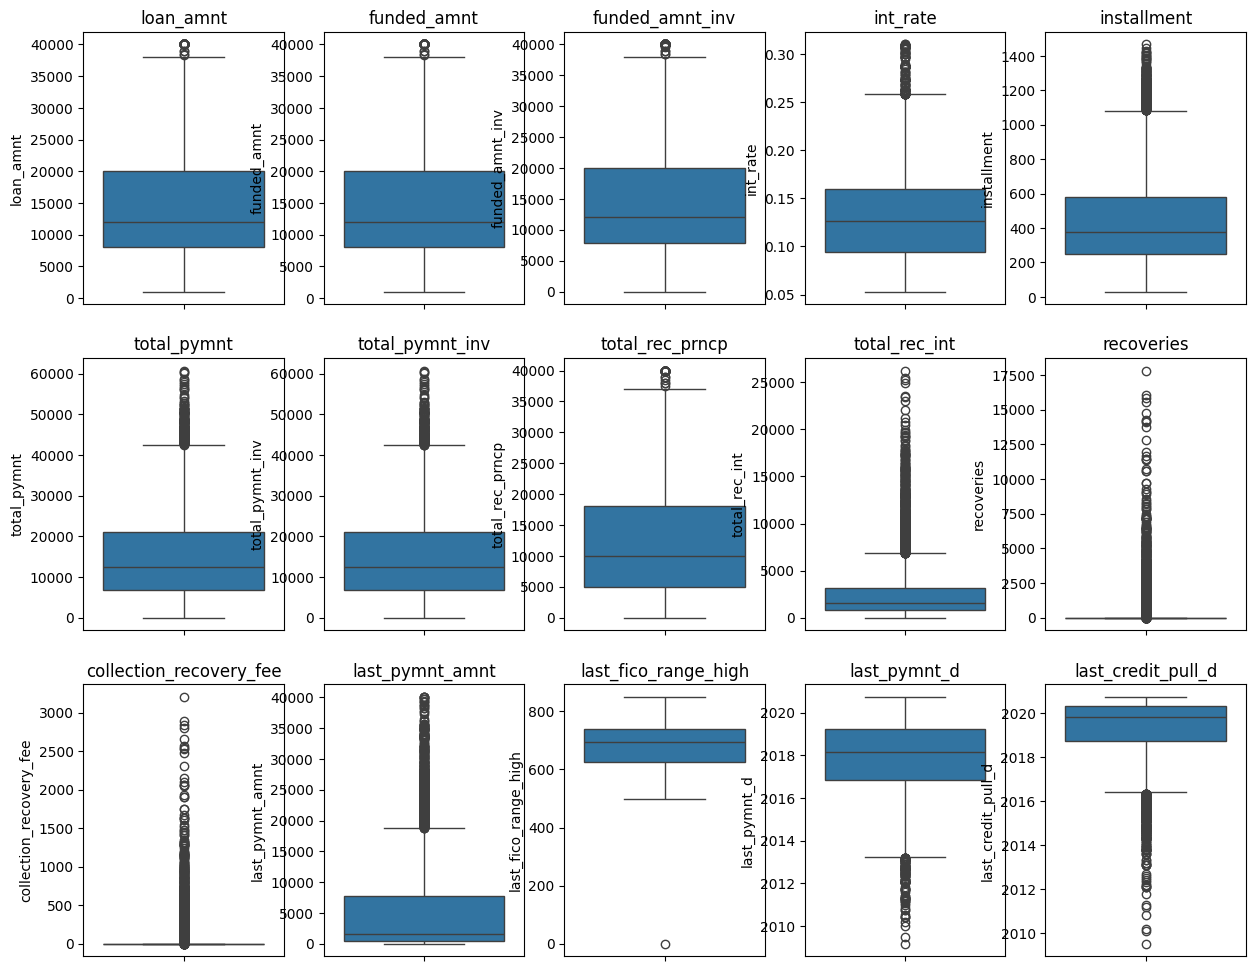

In [39]:
num_cols = 5
num_rows = (len(features) + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4))
axes = axes.flatten()
for i, feature in enumerate(features):
    sns.boxplot(df_combined[feature], ax=axes[i])
    axes[i].set_title(feature)

<Figure size 1000x600 with 0 Axes>

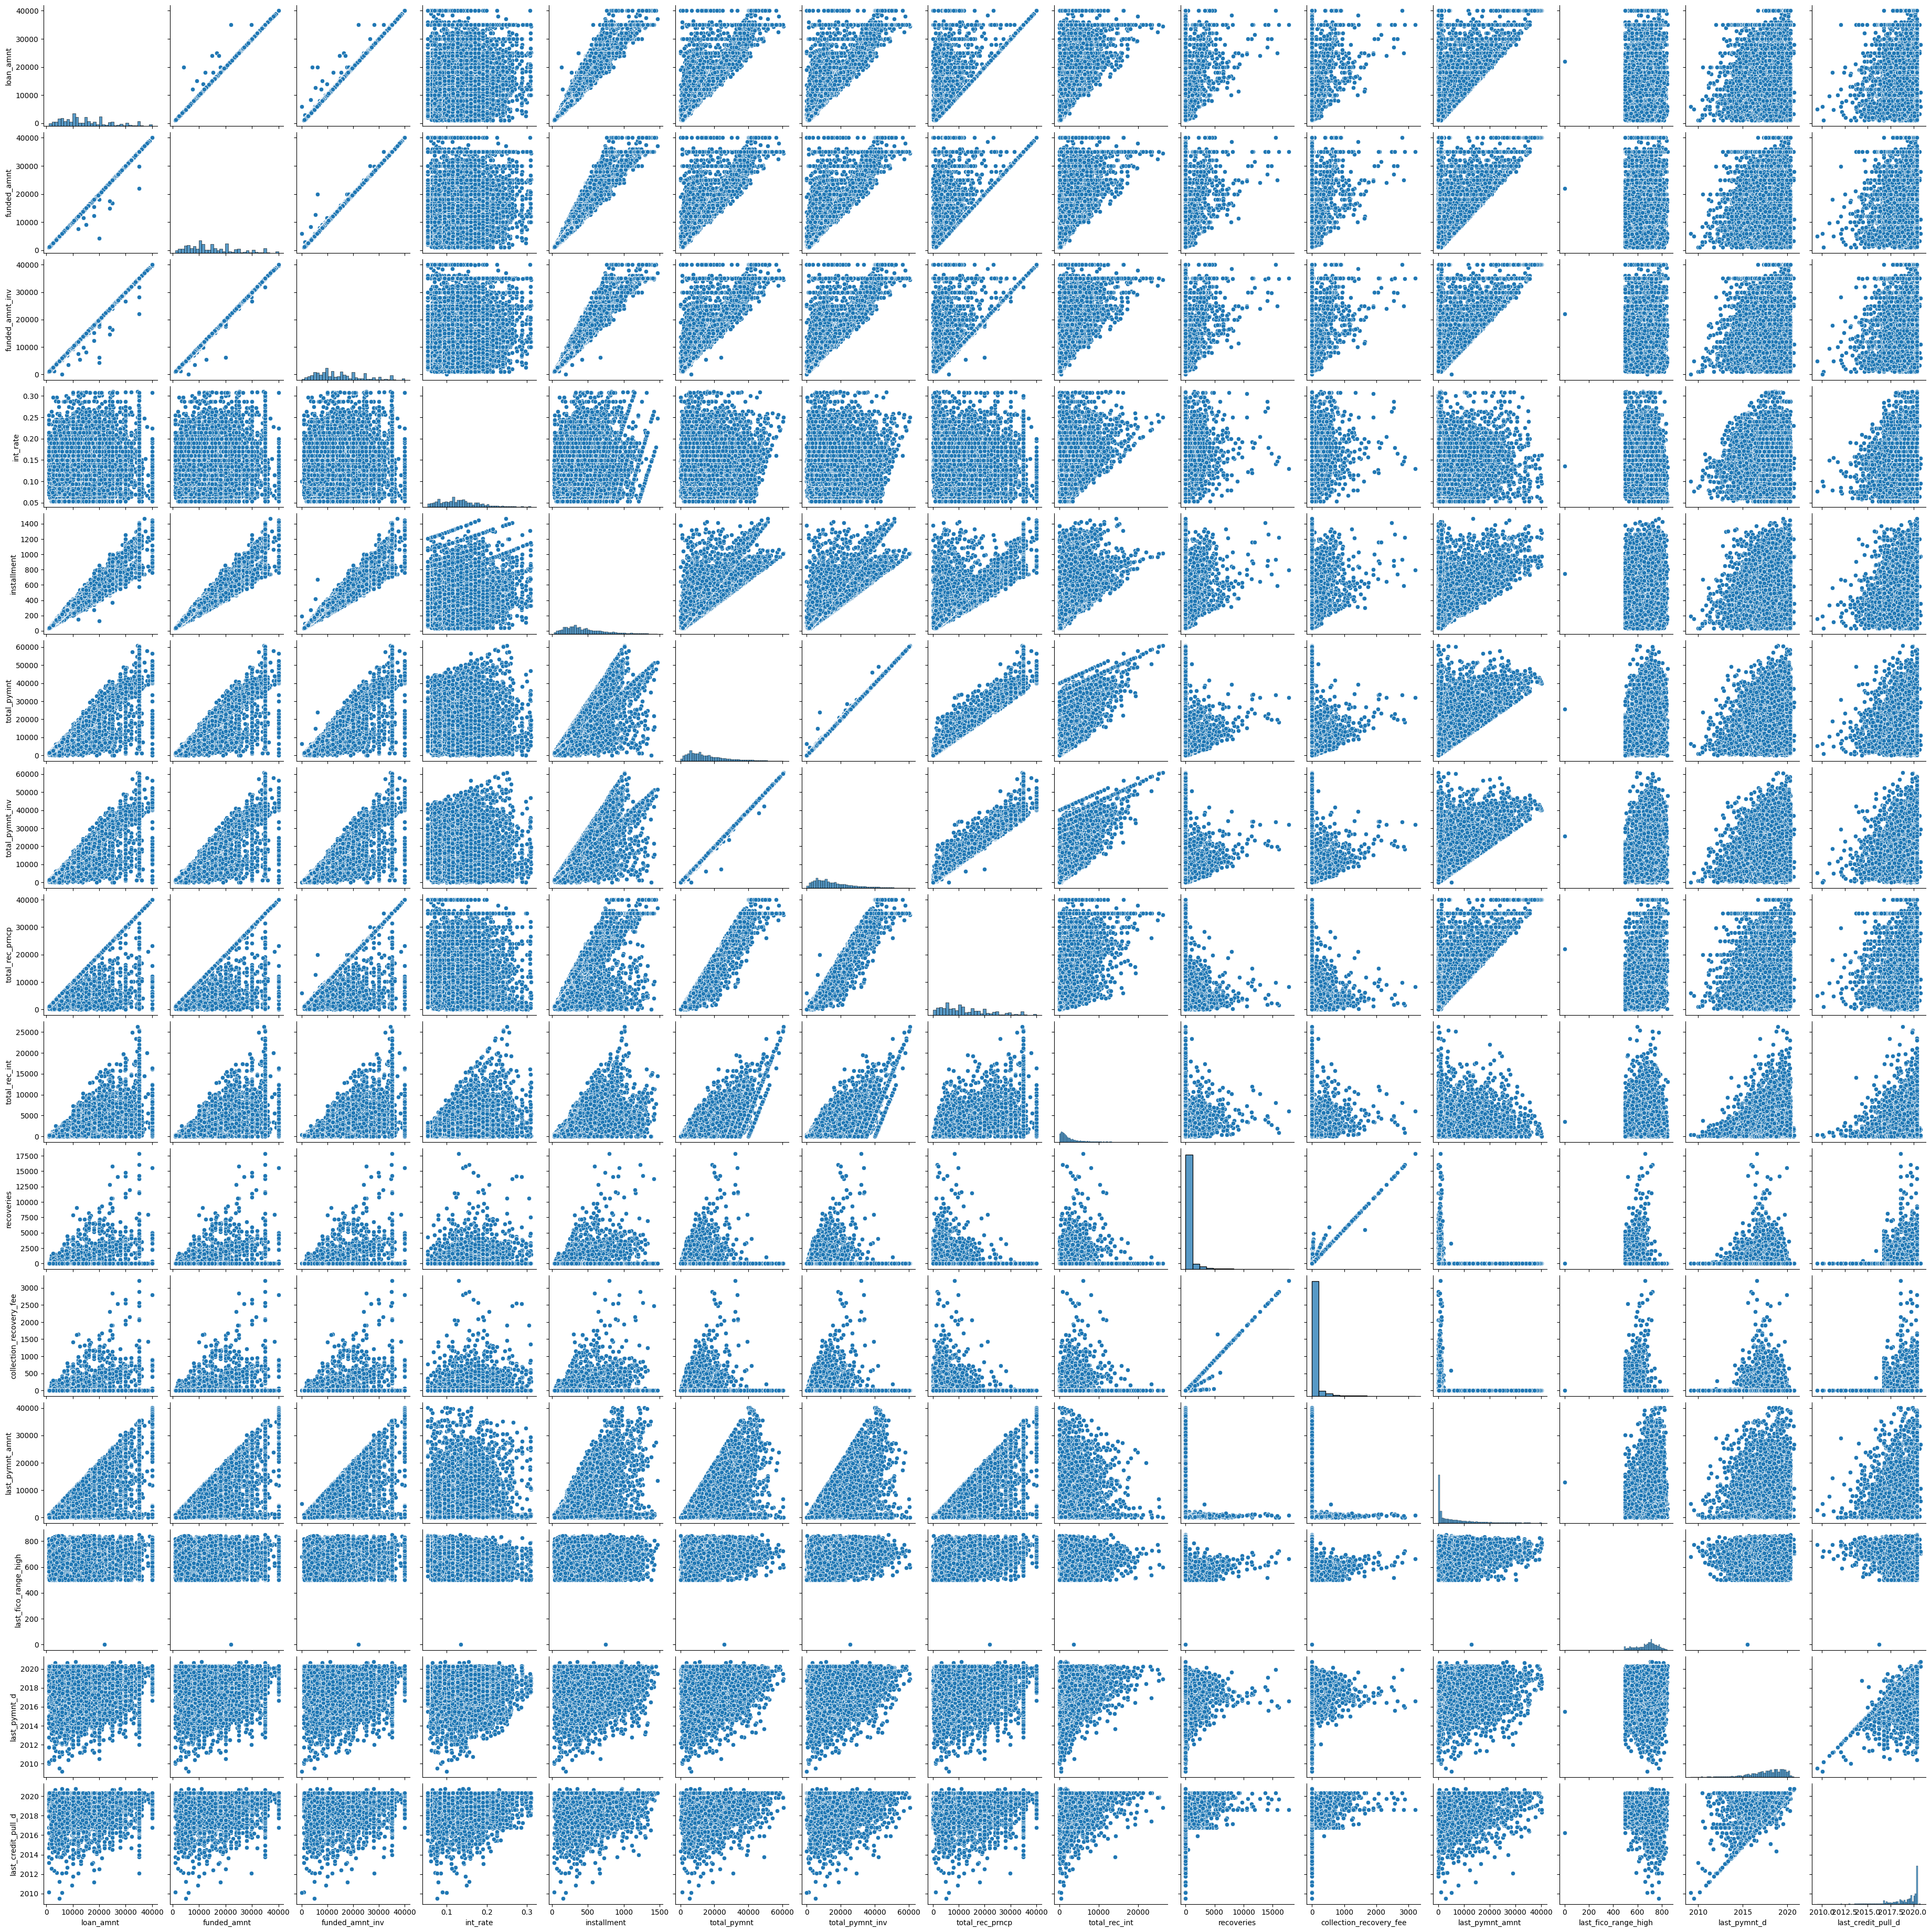

In [40]:
plt.figure(figsize=(10, 6))
sns.pairplot(df_combined[features])
plt.show()

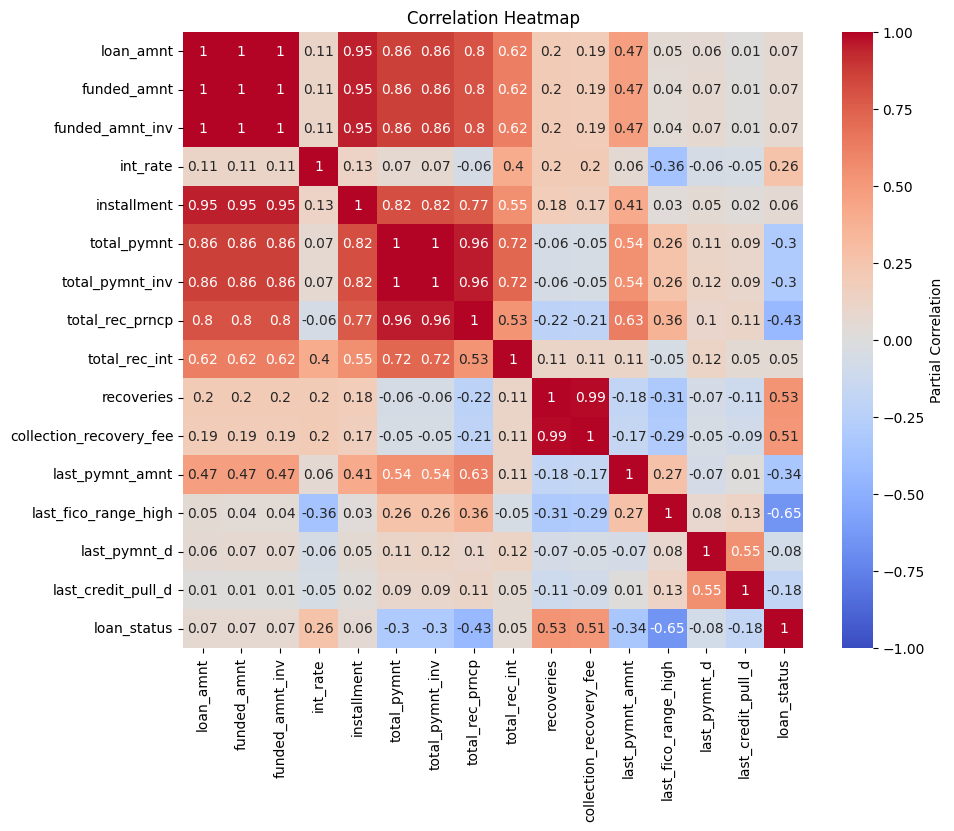

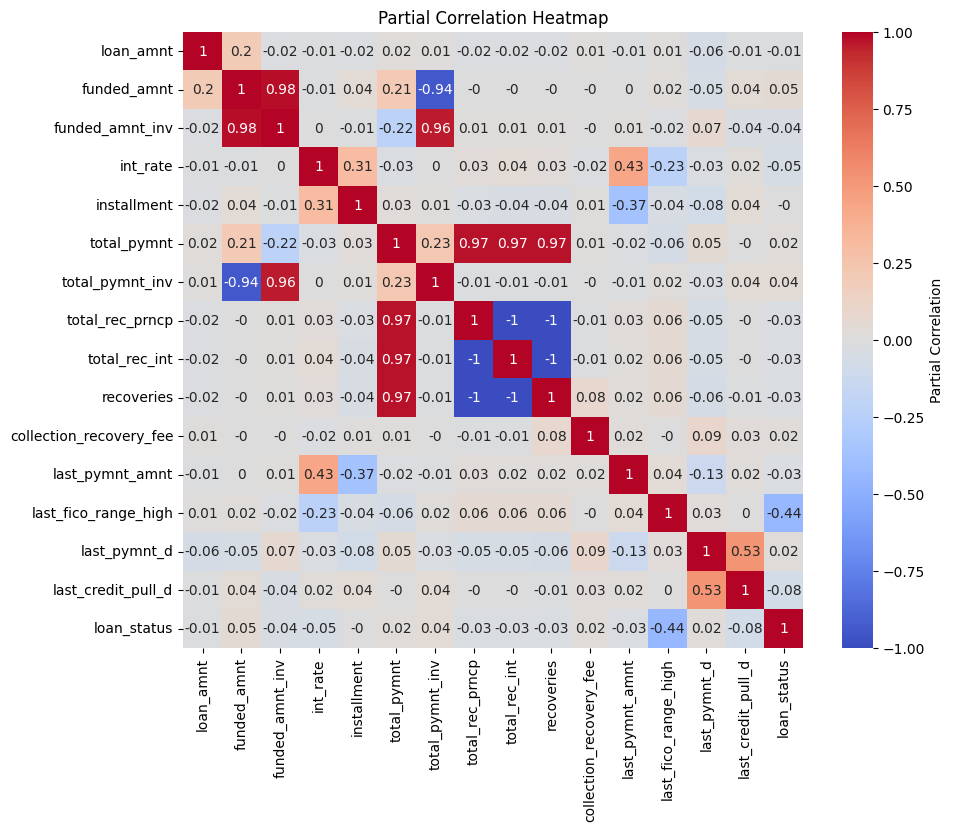

In [41]:
corr_matrix = df_combined.corr(numeric_only=False).round(2)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, cbar_kws={'label': 'Partial Correlation'})
plt.title('Correlation Heatmap')
plt.show()

pcorr_matrix = df_combined.pcorr().round(2)
plt.figure(figsize=(10, 8))
sns.heatmap(pcorr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, cbar_kws={'label': 'Partial Correlation'})
plt.title('Partial Correlation Heatmap')
plt.show()

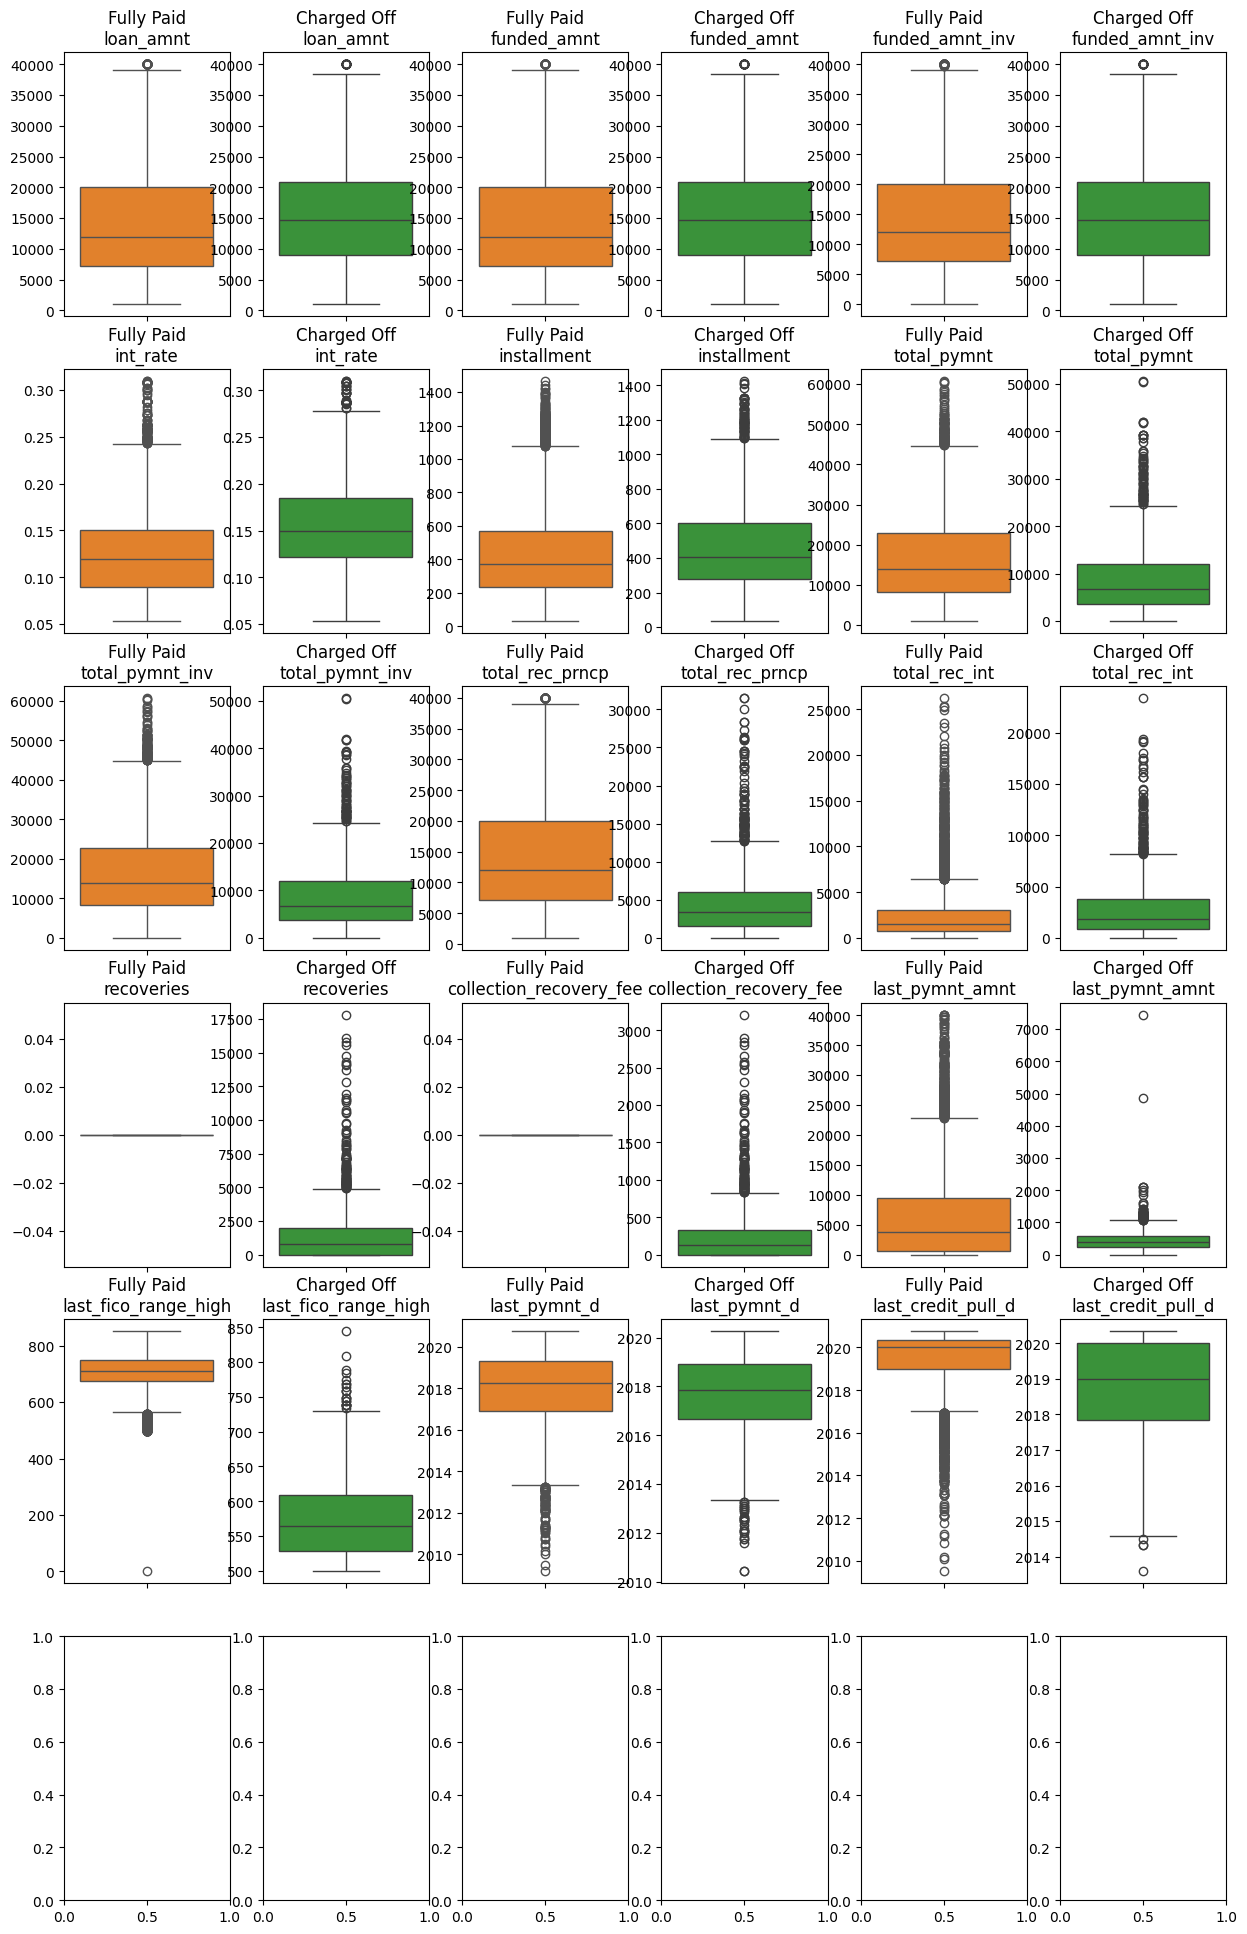

In [42]:
num_cols = 6
num_rows = 6
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4))
axes = axes.flatten()
for i, feature in enumerate(features):
    df_fully_paid = df_combined[df_combined['loan_status'] == 0.0][feature]
    df_charged_off = df_combined[df_combined['loan_status'] == 1.0][feature]
    sns.boxplot(df_fully_paid.tolist(), ax=axes[2*i], color='C1')
    axes[2*i].set_title(f"Fully Paid\n{feature}")
    sns.boxplot(df_charged_off.tolist(), ax=axes[2*i+1], color='C2')
    axes[2*i+1].set_title(f"Charged Off\n{feature}")

In [43]:
from scipy.stats import ttest_ind, f_oneway

fully_paid = df_combined[df_combined['loan_status'] == 0][features]
charged_off = df_combined[df_combined['loan_status'] == 1][features]
t_stat, p_val = ttest_ind(fully_paid, charged_off)

for i, feature in enumerate(features):
    print(f"Feature: {feature}")
    print(f"\tT-statistic: {t_stat[i]}")
    print(f"\tP-value: {p_val[i]}")
    if p_val[i] < 0.05:
        print("\tReject the null hyptothesis ~ Significant difference between the means of binary 'loan_status'")
    else:
        print("\tFail to reject the null hyptothesis ~ No significant difference between the means of binary 'loan_status'")
    print("\n")
    

Feature: loan_amnt
	T-statistic: -6.568831443094591
	P-value: 5.3445014726353685e-11
	Reject the null hyptothesis ~ Significant difference between the means of binary 'loan_status'


Feature: funded_amnt
	T-statistic: -6.611662547059703
	P-value: 4.010521991863141e-11
	Reject the null hyptothesis ~ Significant difference between the means of binary 'loan_status'


Feature: funded_amnt_inv
	T-statistic: -6.625314554813078
	P-value: 3.658392282348605e-11
	Reject the null hyptothesis ~ Significant difference between the means of binary 'loan_status'


Feature: int_rate
	T-statistic: -25.865708360783195
	P-value: 1.7409152969750123e-142
	Reject the null hyptothesis ~ Significant difference between the means of binary 'loan_status'


Feature: installment
	T-statistic: -5.382238351122378
	P-value: 7.536639048094663e-08
	Reject the null hyptothesis ~ Significant difference between the means of binary 'loan_status'


Feature: total_pymnt
	T-statistic: 29.839211829558693
	P-value: 7.17886794317

In [44]:
from pyspark.sql.functions import isnan
df_nan = df.filter(isnan(df['loan_status']))
print(f"Number of NaN data: {df_nan.count()}")

Number of NaN data: 5271


In [45]:
features_collected = df_nan.select(features).collect()
X_unlabeled = np.array([list(feature) for feature in features_collected], dtype=float)

# Modeling

When it comes to choose a machine learnning classifier to predict *loan_status*, two main classes are well known to perform good evaluation: deep neural networks and gradient boosting. *XGBoost* is one of the best model in common Kaggle competition. Several articles compare their performances:

**Article**: [Why do tree-based models still outperform deep learning on typical tabular data?](https://proceedings.neurips.cc/paper_files/paper/2022/hash/0378c7692da36807bdec87ab043cdadc-Abstract-Datasets_and_Benchmarks.html)

**Article**: [Credit Risk Assessment based on Gradient Boosting Decision Tree](https://www.sciencedirect.com/science/article/pii/S1877050920315842)

**Article**: [Deep Learning vs. Gradient Boosting: Benchmarking state-of-the-art machine learning algorithms for credit scoring](https://arxiv.org/abs/2205.10535)

However, I choose to apply a deep multilayer perceptron network to classify loans since I already use a gradient boosting model for data reduction.


### Hyperparameters tuning

Inner hyperparameters tuning whether it is by calling randomized or bayes optimization. I fill a range for each hyperparameter which could be debatable. I have set string in hidden_layer_size hyperparameter which represent the hidden architecture of the MLP classifier since bayes search could not accept a tuple of tuple for its range. This is why I handle it through tuple in the low-level implementation of **MLP**. If you want to optimize hyperparamaters of the model, please run the method *randomized_search* before fitting the model. Note also that it could not explore the initial hyperparameters settings, which is already highly interesting. Nevertheless, it is also highly possible to find a better architecture, for example, with enough iterations of search. Even if the exploration is limited here, as a reminder, there is not a suitable architecture for any problems since there is not prior strategy to find the optimal architecture.

### Interprating method through integrated gradients

Deep neural networks are advanced black-box processes which are difficult to interpret. However, it exists some methods to bring interpration on their well performance. One of the most interesting one is integrated gradients since it checks many axioms. By interpolating gradients, it is possible to identify which features is the most important for the attribution of a deep neural netwoks, whether it concerns classification or regression for example, even in NLP, Computer Vision fields. Here I use **[Captum](https://captum.ai/)** libraby which is linked to **Pytorch** to accelerate its computing. It involves NVIDIA libraries to parallel computing, explaining the quite large size of the docker image of my trained MLP binary classifier. I do not recommend to run *compute_integreated_gradients*  on a large amount to not freeze your computer, which was my case. Nevertheless, it allows to provides the importances of each feature toward the attribution of the *loan_status* attribution. I decided to normalized it in min max standardization to better catch the importances, while the original value is extremely small.

**Article** : [Axiomatic Attribution for Deep Networks](http://proceedings.mlr.press/v70/sundararajan17a.html)

In [46]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset
from captum.attr import IntegratedGradients
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from skopt import BayesSearchCV
import matplotlib.pyplot as plt

torch.manual_seed(1)
torch.cuda.manual_seed_all(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

class MLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_layer_sizes, activation_name, p_dropout):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_layer_sizes = hidden_layer_sizes
        if isinstance(self.hidden_layer_sizes, str):
            self.hidden_layer_sizes = eval(self.hidden_layer_sizes)
        self.activation_name = activation_name
        self.p_dropout = p_dropout
        if activation_name == "Relu":
            self.activation = nn.ReLU()
        elif activation_name == "Sigmoid":
            self.activation = nn.Sigmoid()
        elif activation_name == "Softmax":
            self.activation = nn.Softmax(dim=1)
        elif activation_name == "Tanh":
            self.activation = nn.Tanh()
        elif activation_name == "Leaky_relu":
            self.activation = nn.LeakyReLU()
        else:
            raise ValueError(f'Unsupported activation: {self.activation_name}')
        layers = []
        layers.append(nn.Linear(self.input_size, self.hidden_layer_sizes[0]))
        layers.append(self.activation)
        for i in range(len(self.hidden_layer_sizes) - 1):
            layers.append(nn.Linear(self.hidden_layer_sizes[i], self.hidden_layer_sizes[i + 1]))
            layers.append(self.activation)
            layers.append(nn.Dropout(p=self.p_dropout))
        layers.append(nn.Linear(self.hidden_layer_sizes[-1], self.output_size))
        self.model = nn.Sequential(*layers)
        self.sigmoid = nn.Sigmoid()
        

    def forward_proba(self, X):
        output = self.model(X)
        output = self.sigmoid(output)
        return output.float()
    
    
    def forward(self, X):
        output = self.model(X)
        output = self.sigmoid(output)
        return output


class MLPEstimator():
    def __init__(self, **params):
        self.input_size = params.get("input_size")
        self.output_size = params.get("output_size")
        self.hidden_layer_sizes = params.get("hidden_layer_sizes", (60, 60))
        self.activation_name = params.get("activation_name", "Relu")
        self.loss = params.get("loss", "binary_cross_entropy")
        self.optimizer_name = params.get("optimizer_name", "Adam")
        self.learning_rate = params.get("learning_rate", 1e-3)
        self.batch_size = params.get("batch_size", 50)
        self.weight_decay = params.get("weight_decay", 0)
        self.p_dropout = params.get("p_dropout", 0.2)
        self.early_stopping = params.get("early_stopping", True)
        self.epochs = params.get("epochs", 200)
        self.patience = params.get("patience", 10)
        self.verbose = params.get("verbose", True)
        self.classes_ = 2

        self.device =  'cpu' #'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = MLP(self.input_size, self.output_size, self.hidden_layer_sizes, self.activation_name, self.p_dropout).to(self.device)

        if self.loss == "binary_cross_entropy":
            self.criterion = nn.BCELoss()
        else:
            raise ValueError(f"Unsupported loss: {self.loss}")

        if self.optimizer_name == "SGD":
            self.optimizer = optim.SGD(self.model.parameters(), lr=self.learning_rate, momentum=0.9, weight_decay=self.weight_decay)
        elif self.optimizer_name == "Adam":
            self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        else:
            raise ValueError(f"Unsupported optimizer: {self.optimizer}")
            
    def next_batch(self, inputs, targets, batchSize):
        if isinstance(inputs, np.ndarray):
            inputs_tensor = torch.from_numpy(inputs).float()
        else:
            inputs_tensor = inputs
        if isinstance(targets, np.ndarray):
            targets_tensor = torch.from_numpy(targets).float().unsqueeze(1)
        else:
            targets_tensor = targets
        for i in range(0, inputs_tensor.shape[0], batchSize):
            yield (inputs_tensor[i:i + batchSize], targets_tensor[i:i + batchSize])

    def augment_data(self, X_unlabeled, noise_level=0.1):
        noise = noise_level * torch.randn_like(X_unlabeled)
        return X_unlabeled + noise
            
    def fit(self, X_train, y_train, X_valid, y_valid, X_unlabeled=None):
        train_losses = []
        if self.early_stopping:
            best_loss = float('inf')
            count = 0
            val_losses = []
        if self.verbose:
            epoch_train = tqdm(range(self.epochs), desc="Supervised training ; epochs", unit="epoch")
        else:
            epoch_train = range(self.epochs)
        for _ in epoch_train:
            samples = 0
            epoch_train_loss = 0.0
            self.model.train(True)
            for i, (batchX, batchY) in enumerate(self.next_batch(X_train, y_train, self.batch_size)):
                batchX = batchX.to(self.device)
                batchY = batchY.to(self.device)
                batchY.requires_grad = True
                self.optimizer.zero_grad()
                outputs = self.model(batchX)
                loss = self.criterion(outputs, batchY)
                loss.backward()
                self.optimizer.step()
                epoch_train_loss += loss.item()
                samples += batchY.size(0)
            epoch_train_loss = epoch_train_loss / samples
            train_losses.append(epoch_train_loss)
            if self.verbose:
                epoch_train.set_postfix(train_loss=epoch_train_loss)
            if self.early_stopping:
                batchX_valid = torch.from_numpy(X_valid).float().to(self.device)
                batchY_valid = torch.from_numpy(y_valid).float().unsqueeze(1).to(self.device)
                outputs_valid = self.model(batchX_valid)
                loss_valid = self.criterion(outputs_valid, batchY_valid)
                valid_loss = loss_valid.item()
                val_losses.append(valid_loss)
                if self.verbose:
                    epoch_train.set_postfix(valid_loss=valid_loss)
                if valid_loss < best_loss:
                    best_loss = valid_loss
                    count = 0
                else:
                    count += 1
                if count >= self.patience:
                    break
        if self.verbose:
            epoch_train.close()
        if X_unlabeled is not None:
            train_losses_unlabeled = list()
            if self.early_stopping:
                best_loss_unlabeled = float('inf')
                count_unlabeled = 0
                val_losses_unlabeled = []
            X_unlabeled = torch.from_numpy(X_unlabeled).float().to(self.device)
            augmented_X_unlabeled = self.augment_data(X_unlabeled).to(self.device)
            self.model.eval()
            with torch.no_grad():
                pseudo_labels = self.model(X_unlabeled).to(self.device)
                pseudo_labels = (pseudo_labels > 0.5).float().to(self.device)
            
            X_combined = torch.cat((torch.from_numpy(X_train).float().to(self.device), augmented_X_unlabeled), 0).to(self.device)
            y_combined = torch.cat((torch.from_numpy(y_train).float().unsqueeze(1).to(self.device), pseudo_labels), 0).to(self.device)

            if self.verbose:
                epoch_train_unlabeled = tqdm(range(self.epochs), desc="Semi-supervised training ; epochs", unit="epoch")
            else:
                epoch_train_unlabeled = range(self.epochs)
            for _ in epoch_train_unlabeled:
                samples = 0
                epoch_train_loss = 0.0
                self.model.train(True)
                for i, (batchX, batchY) in enumerate(self.next_batch(X_combined, y_combined, self.batch_size)):
                    batchX = batchX.to(self.device)
                    batchY = batchY.to(self.device)
                    batchY.requires_grad = True
                    self.optimizer.zero_grad()
                    outputs = self.model(batchX)
                    loss = self.criterion(outputs, batchY)
                    loss.backward()
                    self.optimizer.step()
                    epoch_train_loss += loss.item()
                    samples += batchY.size(0)
                epoch_train_loss = epoch_train_loss / samples
                train_losses_unlabeled.append(epoch_train_loss)
                if self.verbose:
                    epoch_train_unlabeled.set_postfix(train_loss=epoch_train_loss)
                if self.early_stopping:
                    outputs_valid = self.model(batchX_valid)
                    loss_valid_unlabeled = self.criterion(outputs_valid, batchY_valid)
                    valid_loss = loss_valid_unlabeled.item()
                    val_losses_unlabeled.append(valid_loss)
                    if self.verbose:
                        epoch_train_unlabeled.set_postfix(valid_loss=valid_loss)
                    if valid_loss < best_loss_unlabeled:
                        best_loss_unlabeled = valid_loss
                        count_unlabeled = 0
                    else:
                        count_unlabeled += 1
                    if count_unlabeled >= self.patience:
                        break
            if self.verbose:
                epoch_train_unlabeled.close()
        return self

    def forward(self, X):
        self.model.eval()
        X = torch.from_numpy(X).float().to(self.device)
        self.model.to(self.device)
        y_pred = self.model.forward(X)
        if self.device == "cuda":
            y_pred = y_pred.cpu().detach().numpy()
        else:
            y_pred = y_pred.detach().numpy()
        return (y_pred > 0.5).astype(int)

    def forward_proba(self, X):
        self.model.eval()
        X = torch.from_numpy(X).float().to(self.device)
        self.model.to(self.device)
        y_proba = self.model.forward_proba(X)
        if self.device == "cpu":
            y_proba = y_proba.cpu().detach().numpy().astype(float)
        else:
            y_proba = y_proba.detach().numpy().astype(float)
        y_proba = y_proba.squeeze().astype(np.float32)
        return np.column_stack((1 - y_proba, y_proba))

    def get_params(self):
        params = {
            "input_size": self.input_size,
            "output_size": self.output_size,
            "hidden_layer_sizes": self.hidden_layer_sizes,
            "activation_name": self.activation_name,
            "loss": self.loss,
            "optimizer_name": self.optimizer_name,
            "learning_rate": self.learning_rate,
            "batch_size": self.batch_size,
            "weight_decay": self.weight_decay,
            "p_dropout": self.p_dropout,
            "early_stopping": self.early_stopping,
            "epochs": self.epochs,
            "patience": self.patience,
            "verbose": self.verbose
        }
        return params
    
class MLPBinaryClassifier(nn.Module):
    def __init__(self, X, y, split_test, X_unlabeled=None, **params):
        super(MLPBinaryClassifier, self).__init__()
        self.model = MLPEstimator(**params)
        self.X = X
        self.X_unlabeled = X_unlabeled
        self.y = y
        
        self.y = MLPBinaryClassifier.float_to_class(self.y).ravel()
        
        self.split_test = split_test
        self.split_data()
        
        self.standardize(self.X_train_valid)
        self.X_train_standard = self.standardize_X(self.X_train)
        self.X_valid_standard = self.standardize_X(self.X_valid)
        if isinstance(self.X_unlabeled, np.ndarray):
            self.X_unlabeled_standard = self.standardize_X(self.X_unlabeled)
        else :
            self.X_unlabeled_standard = None
        self.y_train_standard = self.y_train
        self.y_valid_standard = self.y_valid

    @staticmethod
    def float_to_class(y):
        threshold = 0.5
        return (y >= threshold).astype(int)
    
    def split_data(self):
        self.X_train_valid, self.X_test, self.y_train_valid, self.y_test = train_test_split(
            self.X, self.y, test_size=self.split_test, shuffle=True, random_state=1, stratify=self.y)
        self.X_train, self.X_valid, self.y_train, self.y_valid = train_test_split(
            self.X_train_valid, self.y_train_valid, test_size=0.1, shuffle=True, random_state=1, stratify=self.y_train_valid)
    

    def standardize(self, X):
        self.scaler_X_train = StandardScaler()
        self.scaler_X_train.fit(X)         


    def standardize_X(self, X):
        X_new = self.scaler_X_train.transform(X)
        return X_new

    def bayes_search(self, param_bayes, n_iter, n_points=1, cv=5, scoring='accuracy',
                 verbose=3, n_jobs=1) :
        cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=1)
        bayes_search = BayesSearchCV(self.model, param_bayes, n_iter=n_iter,
                                     n_points=n_points, cv=cv, scoring=scoring,
                                     verbose=verbose, return_train_score=True,
                                     n_jobs=n_jobs, random_state=1)
        bayes_search.fit(self.X_train_standard, self.y_train_standard)
        results_df = pd.DataFrame(bayes_search.cv_results_)
        self.model = bayes_search.best_estimator_
        print(f'Best hyperparameters bayes search : {bayes_search.best_params_}')
        return results_df

    def randomized_search(self, param_randomized, n_iter, cv=5, scoring='accuracy',
                      verbose=3, n_jobs=1) :
        cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=1)
        randomized_search = RandomizedSearchCV(self.model, param_randomized,
                                               n_iter=n_iter, cv=cv, scoring=scoring,
                                               verbose=verbose, return_train_score=True,
                                               n_jobs=n_jobs, random_state=1)
        randomized_search.fit(self.X_train_standard, self.y_train_standard)
        results_df = pd.DataFrame(randomized_search.cv_results_)
        self.model = randomized_search.best_estimator_
        print(f'Best hyperparameters randomized search : {randomized_search.best_params_}')
        return results_df

    def fit(self):
        self.model.fit(self.X_train_standard, self.y_train_standard, self.X_valid_standard, self.y_valid_standard, self.X_unlabeled_standard)

    def forward(self, X):
        X_standard = self.standardize_X(X)
        y_pred = self.model.forward(X_standard)
        return y_pred
    
    def forward_proba(self, X):
        X_standard = self.standardize_X(X)
        y_pred = self.model.forward_proba(X_standard)
        return y_pred

    @staticmethod
    def compute_metrics(metric, y_true, y_pred):
        y_pred = MLPBinaryClassifier.float_to_class(y_pred)
        accuracy = metrics.accuracy_score(y_true, y_pred)
        precision = metrics.precision_score(y_true, y_pred, average='weighted', zero_division=0)
        recall = metrics.recall_score(y_true, y_pred, average='weighted')
        f1 = metrics.f1_score(y_true, y_pred, average='weighted')
        metrics_dict = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1': f1,
        }
        if metric != 'all':
            metrics_dict = {metric: metrics_dict[metric]}
        return metrics_dict


    def model_performance(self, metric='all'):
        y_pred_train = self.forward(self.X_train)
        scores_train = MLPBinaryClassifier.compute_metrics(metric, self.y_train, y_pred_train)
        y_pred_test = self.forward(self.X_test)
        scores_test = MLPBinaryClassifier.compute_metrics(metric, self.y_test, y_pred_test)
        data = {}
        for key, value in scores_train.items():
            data['Train Set - '+key] = [value]
        for key, value in scores_test.items():
            data['Test Set - '+key] = [value]
        df_scores = pd.DataFrame(data=data).T
        df_scores.columns = ['Scores']
        return df_scores

    def model_performance_test(self, X_test, y_test, metric='all'):
        y_pred_test = self.forward(X_test)
        scores_test = MLPBinaryClassifier.compute_metrics(metric, y_test, y_pred_test)
        data = {}
        for key, value in scores_test.items():
            data['Test Set - '+key] = [value]
        df_scores = pd.DataFrame(data=data).T
        df_scores.columns = ['Scores']
        return df_scores

    def receiver_operating_characteristics(self):
        y_pred_test = self.forward(self.X_test)
        fpr, tpr, thresholds = metrics.roc_curve(self.y_test, y_pred_test)
        plt.plot(fpr, tpr)
        plt.title("Receiver Operating Characteristics")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.show()

    def compute_integrated_gradients(self, X, baseline=None, steps=50):
        def preprocess_input(X):
            return torch.tensor(X, dtype=torch.float32).to(self.model.device)
        input_tensor = preprocess_input(X)
        if baseline is None:
            baseline = torch.zeros_like(input_tensor)
        self.model.model.to(self.model.device)
        integrated_gradients = IntegratedGradients(self.model.model)
        attributions = integrated_gradients.attribute(input_tensor, baseline, target=0, n_steps=steps)
        if self.model.device == "cuda":
            attributions = attributions.cpu()
        attributions_df = pd.DataFrame(attributions.detach().numpy().astype(float), columns=features)
        avg_attributions = attributions_df.mean(axis=0)
        avg_abs_attributions = avg_attributions.abs()
        def custom_minmax_scaler(data, feature_range=(0, 100)):
            min_val = np.min(data)
            max_val = np.max(data)
            if max_val - min_val == 0:
                return np.zeros_like(data) if feature_range[0] == 0 else np.full_like(data, feature_range[0])
            scale = (feature_range[1] - feature_range[0]) / (max_val - min_val)
            min_range = feature_range[0]
            scaled_data = scale * (data - min_val) + min_range
            return scaled_data
        normalized_data = custom_minmax_scaler(avg_abs_attributions.values.reshape(-1, 1)).astype(float)
        np.set_printoptions(suppress=True, precision=2)
        normalized_attributions = pd.DataFrame(normalized_data, columns=['attribution'], index=features)
        sorted_attributions = normalized_attributions.sort_values(by="attribution", ascending=False)
        return sorted_attributions

In [47]:
from scipy.stats import loguniform, uniform
from skopt.space import Real

params = {    
    "init" : {
        "input_size" : len(features),
        "output_size" : 1,
        "hidden_layer_sizes" : (60,60),
        "activation_name" : "Relu",
        "optimizer_name" : "Adam",
        "learning_rate" : 1e-3,
        "batch_size" : 50,
        "weight_decay" : 0,
        "p_dropout" : 0.3,
        "loss" : "binary_cross_entropy",
        "early_stopping" : True,
        "epochs" : 200,
        "patience" : 10,
        "verbose" : True
    },
    "randomized": {
        "hidden_layer_sizes" : [(10,),(50,),(100,),(10,10),(50,50),(60,60),(100,50),(100,100),(100,50,25)],
        "activation_name" :  ["Relu", "Sigmoid", "Tanh", "Leaky_relu", "Softmax"],
        "learning_rate" : loguniform(1e-4, 1e-1),
        "batch_size" : list(np.arange(10,500, 10)),
        "optimizer_name" : ["Adam", "SGD"],
        "alpha" : np.logspace(-3,0,19),
        "weight_decay" : loguniform(1e-5, 1),
        "p_dropout" : uniform(0, 0.4)   
    },
    "bayes": {
        "hidden_layer_sizes" : ["(10,)","(50,)","(100,)","(10,10)","(50,50)","(60,60)","(100,50)","(100,100)","(100,50,25)"],
        "activation_name" :  ["Relu", "Sigmoid", "Tanh", "Leaky_relu", "Softmax"],
        "learning_rate" : Real(1e-4, 1e-1, prior='log-uniform'),
        "batch_size" : list(np.arange(10,500, 10)),
        "optimizer_name" : ["Adam", "SGD"],
        "alpha" : np.logspace(-3,0,19),
        "weight_decay" : Real(1e-5, 1, prior='log-uniform'),
        "p_dropout" : Real(0, 0.4, prior='uniform')
    }
}

model_mlp = MLPBinaryClassifier(X=X_labeled, y=y_labeled, X_unlabeled=X_unlabeled, split_test=0.2, **params["init"])

In [48]:
n_iter = 5
n_points=1
cv=5
scoring='accuracy'
verbose=3
n_jobs=-1

In [49]:
'''
model_mlp.bayes_search(
    param_bayes=params['bayes'],
    n_iter=n_iter,
    n_points=n_points,
    cv=cv,
    scoring=scoring,
    n_jobs=n_jobs
)
'''

"\nmodel_mlp.bayes_search(\n    param_bayes=params['bayes'],\n    n_iter=n_iter,\n    n_points=n_points,\n    cv=cv,\n    scoring=scoring,\n    n_jobs=n_jobs\n)\n"

In [50]:
'''
model_mlp.randomized_search(
    param_randomized=params['randomized'],
    n_iter=n_iter,
    cv=cv,
    scoring=scoring,
    n_jobs=n_jobs
)
'''

"\nmodel_mlp.randomized_search(\n    param_randomized=params['randomized'],\n    n_iter=n_iter,\n    cv=cv,\n    scoring=scoring,\n    n_jobs=n_jobs\n)\n"

In [51]:
model_mlp.model.get_params()

{'input_size': 15,
 'output_size': 1,
 'hidden_layer_sizes': (60, 60),
 'activation_name': 'Relu',
 'loss': 'binary_cross_entropy',
 'optimizer_name': 'Adam',
 'learning_rate': 0.001,
 'batch_size': 50,
 'weight_decay': 0,
 'p_dropout': 0.3,
 'early_stopping': True,
 'epochs': 200,
 'patience': 10,
 'verbose': True}

In [52]:
model_mlp.fit()

Semi-supervised training ; epochs:   5%|▌         | 10/200 [00:04<01:30,  2.10epoch/s, valid_loss=0.174]


# Evaluation



For a classification problem, few elements must be identified:

- **TP** (True Positives) is the number of correctly classified *Charged Off* loans.
- **TN** (True Negatives) is the number of correctly classified *Fully Paid* loans.
- **FP** (False Positives) is the number of *Fully Paid* loans incorrectly classified as 'Charged Off'.
- **FN** (False Negatives) is the number of *Charged Off* loans incorrectly classified as 'Fully Paid'.

Various metrics exist to evaluate the performance of the model:

*Precision, Recall and F1Score provide a better understanding of how well the model is performing in identifying the *Charge Off* loans, the minority target of the dataset.*

### Accuracy

This metrics is the main metric to evaluate the model through the hyperparameters search.

$$ Accuracy = \frac{TP + TN}{TP + TN + FP + FN} $$

### Precision

$$ Precision = \frac{TP}{TP + FP} $$

### Recall - Sensitivity

$$ Accuracy = \frac{TP}{TP + FN} $$

### F1Score

$$ F1Score = 2 * \frac{Precision * Recall}{Precision + Recall} $$

### ROC-AUC

The area under the receiver operation characteristic curve is a single value summarizing the overall ability of the model.

### Observations

The trained model performed well a binary classification on the dataset since metrics are near from 1, i.e. higher than 0,95.

In [53]:
model_mlp.model_performance()

Scores
Train Set - Accuracy   0.910020
Train Set - Precision  0.937601
Train Set - Recall     0.910020
Train Set - F1         0.915543
Test Set - Accuracy    0.908649
Test Set - Precision   0.936249
Test Set - Recall      0.908649
Test Set - F1          0.914239

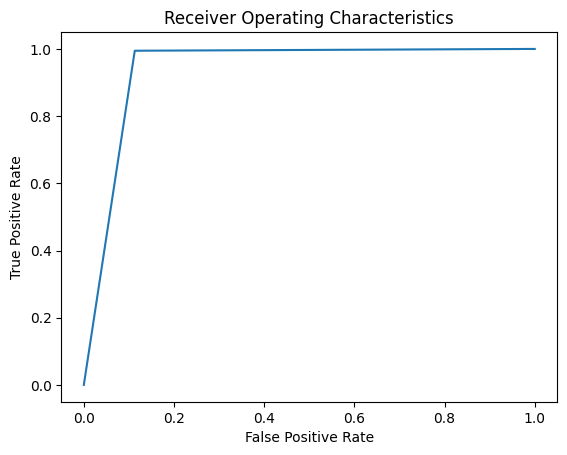

In [54]:
model_mlp.receiver_operating_characteristics()

In [55]:
df_test = df_spark.sample(fraction=0.05, seed=30)
df_test = df_test.dropna(subset=['loan_status'])
features_collected = df_test.select(features).collect()
X_test = np.array([list(feature) for feature in features_collected])
target_collected = df_test.select('loan_status').collect()
y_test = np.array([feature['loan_status'] for feature in target_collected])
y_test = y_test.astype(int)

In [56]:
model_mlp.model_performance_test(X_test, y_test)

Scores
Test Set - Accuracy   0.903984
Test Set - Precision  0.935457
Test Set - Recall     0.903984
Test Set - F1         0.910487

In [57]:
single_value_collected = df_spark.sample(withReplacement=False, fraction=0.0001, seed=11).limit(1).collect()[0]
single_value = np.array([value for key, value in single_value_collected.asDict().items() if key != 'loan_status']).reshape(1,-1).astype(float)
single_value_target = np.array([value for key, value in single_value_collected.asDict().items() if key == 'loan_status'])

In [58]:
model_mlp.compute_integrated_gradients(single_value)

attribution
total_rec_prncp           100.000000
total_pymnt                79.576956
total_pymnt_inv            69.552598
funded_amnt                45.987582
loan_amnt                  40.753412
funded_amnt_inv            31.260849
last_pymnt_d                9.384556
last_pymnt_amnt             7.146343
total_rec_int               3.582259
last_credit_pull_d          3.167419
last_fico_range_high        3.001078
installment                 1.314974
int_rate                    0.000206
recoveries                  0.000000
collection_recovery_fee     0.000000

In [59]:
torch.save(model_mlp, 'lendingclub_mlp_binary_classifier.pt')

# App

The **docker** image of the app is located [here](https://hub.docker.com/repository/docker/yanncauchepin/kaggle_lendingclub/general).

**Github** repository is located [here](https://github.com/yanncauchepin/Kaggle_LendingClub).